# Identifying Different Restaurant Clusters in Downtown Toronto
### Applied Data Science Capstone by IBM/Coursera

## Table of Contents
- [1. Introduction: Business Problem](#introduction)
- [2. Data](#data)
- [3. Methodology](#methodology)
    - [3.1. Data Collection: Downtown Toronto Neighbourhoods](#datacollection1)
    - [3.2. Data Collection: Foursquare Location Data](#datacollection2)
    - [3.3. Data Wrangling and Preparation](#datawrangling)
    - [3.4. Clustering Algorithm](#clustering)
    - [3.5. Examining Clusters of Chosen Model](#clusterexamination)
- [4. Results](#results)
- [5. Discussion](#discussion)
- [6. Conclusion](#conclusion)

## Scope of Work

This piece is intended as a training exercise to put into practice skills and toolset required to implement a data science project through its steps and stages, including Problem Definition, Data Collection, Data Analysis, Wrangling and Preparation, Model Selection and Report Writing.

Anyone who is interested in the resulted recommendations needs to understand that further and deeper analysis is required to make more informed decisions.

<a id='introduction'></a>

## 1. Introduction: Business Problem

For this Capstone Project I would like to explore an idea of opening a specific type of restaurant (some particular cuisine or perhaps Vegetarian or Vegan place) in Downtown Toronto.

Among other things that should go into Business Plan Development of that idea it would be useful to:
- Explore the current spatial distribution of all restaurants based on Foursquare location data.
- Use the machine learning clustering algorithm to identify different restaurant clusters in Downtown Toronto.

The results of that analysis could be valuable to potential stakeholders who plan to invest in the idea of opening a restaurant in Downtown Toronto and should help to answer the following question:

**Where would we recommend our potential stakeholders open it and whether they should pursue opening some particular type or types of restaurants that they think of?**

<a id='data'></a>

## 2. Data

In order to answer the above mentioned question the following approach and data will be used:
- We will use the results of parsing the Wikipedia page of Toronto's postal codes from week 3 assignment.
- Because we narrow down analysis to just one borough (Downtown Toronto), we will not combine neighbourhoods with the same postal code as we did in week 3 assignment. That way we will have more distinct neighbourhoods for our clustering algorithm to work with.
- Then as in week 3 assignment we will get coordinates for all neighbourhoods in Downtown Toronto with `geocoder` library.
- Then for each coordinate we will make an `explore?` Foursquare request with one of the parameters `query='restaurant'` to search for all restaurants in the particular area. We will explore different values for `radius` and `limit` parameters so that we can get more results for our clustering algorithm to work with.
- Finally we will execute our clustering algorithm as we did in week 3 assignment and explore the results and hopefully get some valuable insights into the question we are trying to answer.

<a id='methodology'></a>

## 3. Methodology

<a id='datacollection1'></a>

### 3.1. Data Collection: Downtown Toronto Neighbourhoods

In this section we will:
- Parse the Wikipedia page that contains the list of Toronto neighbourhoods.
- Extract that data into a pandas dataframe with Downtown Toronto neighbourhoods.
- Get the coordinates for those neighbourhoods and save the resulted dataframe.

In [1]:
# import initial libraries

import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

In [2]:
# get the source code from the wikipedia page and pass it to the beautifulsoup constructor

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)

In [3]:
# extract the table of postal codes and iterate through the first 3 rows and check the results

table = soup.table

In [4]:
# create pandas dataframe

columns = ['PostalCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']
toronto_df = pd.DataFrame(columns=columns)

In [5]:
# populate dataframe with data from soup object

for i, row in enumerate(table.find_all('tr')):
    row_list = []
    for cell in row.find_all('td'):
        row_list.append(cell.text.replace('\n', ''))
    if row_list: 
        toronto_df.loc[i, ['PostalCode', 'Borough', 'Neighbourhood']] = row_list

In [6]:
# extract rows with Downtown Toronto borough

toronto_df = toronto_df[toronto_df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)

In [7]:
# check if there are any neighbourhoods not assigned

(toronto_df['Neighbourhood'] == 'Not assigned').value_counts()

False    37
Name: Neighbourhood, dtype: int64

In [8]:
# get the coordinates

import geocoder

for i in toronto_df.index:
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(toronto_df.loc[i, 'Neighbourhood']))
        lat_lng_coords = g.latlng
    
    toronto_df.loc[i, ['Latitude', 'Longitude']] = lat_lng_coords

In [9]:
# check we got coordinates for all neighbourhoods

toronto_df[['Latitude', 'Longitude']].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [10]:
# print our dataframe

toronto_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.6395,-79.3832
1,M5A,Downtown Toronto,Regent Park,43.6607,-79.3603
2,M5B,Downtown Toronto,Ryerson,43.6488,-79.4025
3,M5B,Downtown Toronto,Garden District,43.6579,-79.3756
4,M5C,Downtown Toronto,St. James Town,43.6708,-79.3735


In [11]:
# visualize downtown toronto neighbourhoods on the map

import folium

location_toronto = [43.648503, -79.383558]
map_toronto = folium.Map(location=location_toronto, zoom_start=12)

for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighbourhood']):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        tooltip=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

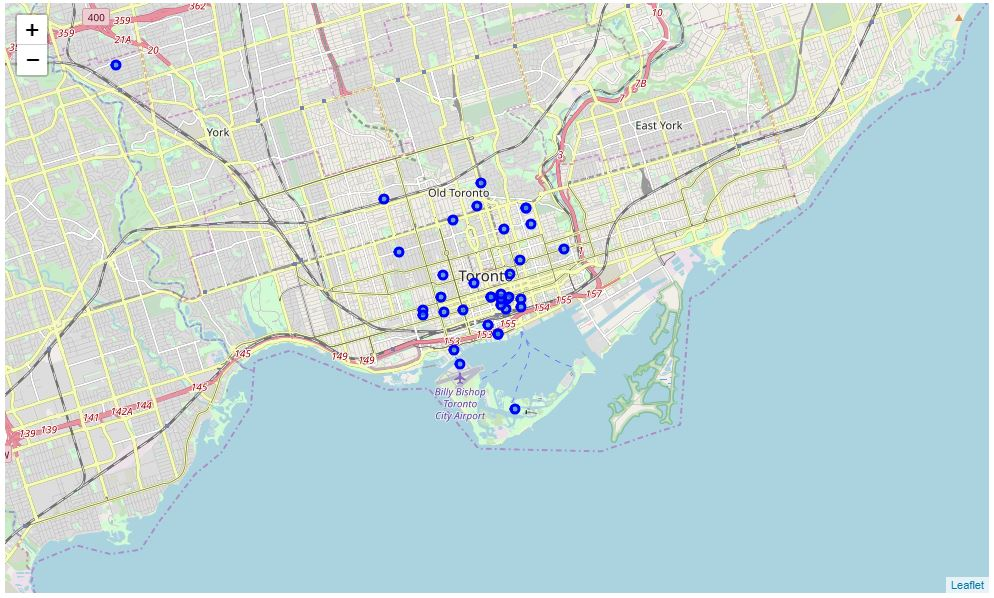

In [12]:
# remove an outlier - neighbourhood King, not correctly identified by geocoder

toronto_df = toronto_df[toronto_df['Neighbourhood'] != 'King']

In [13]:
# remove two island neighbourhoods - our focus is mainly mainland

toronto_df = toronto_df[(toronto_df['Neighbourhood'] != 'Island airport') & (toronto_df['Neighbourhood'] != 'Toronto Islands')]
toronto_df.reset_index(drop=True, inplace=True)

In [14]:
# check the shape of the dataframe

toronto_df.shape

(34, 5)

In [15]:
# save the resulted dataframe to csv

toronto_df.to_csv('final_dt_toronto_df.csv')

<a id='datacollection2'></a>

### 3.2. Data Collection: Foursquare Location Data

In this section we will:

- Load our Foursquare credentials and define a function to make a Foursquare request.
- Experiment with different parameters of `radius` and `limit` for a Foursquare request and check the number of venues returned, total and per each neighbourhood.
- Create a pandas dataframe with names, categories and coordinates of the venues for further data wrangling and preparation.

In [16]:
# open txt file with foursquare credentials and read it into CLIENT_ID and CLIENT_SECRET

with open('foursquare.txt', 'r') as file:
    CLIENT_ID = file.readline().replace('\n', '')
    CLIENT_SECRET = file.readline().replace('\n', '')

In [17]:
# define version, query and initial radius and limit

VERSION = '20190407'
RADIUS = 500
QUERY = 'Restaurant'
LIMIT = 100

In [18]:
# define function to check different radius and limit

def make_request(radius=RADIUS, limit=LIMIT):

    # initialize an empty list of all venues 
    venues_list = []

    for name, lat, lng in zip(
        toronto_df['Neighbourhood'],
        toronto_df['Latitude'],
        toronto_df['Longitude']):

        # make Foursquare API request
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            QUERY,
            limit)

        results = requests.get(url).json()['response']['groups'][0]['items']

        # append relevant information for all venues
        venues_list.append([(
            name,
            venue['venue']['name'],
            venue['venue']['categories'][0]['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng']) for venue in results])
        
    return venues_list

In [19]:
# make request with radius=500 and limit=100

venues_list = make_request()

venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
venues_df.columns = ['Neighbourhood', 'VenueName', 'VenueCategory', 'VenueLatitude', 'VenueLongitude']

venues_df.head()

,Neighbourhood,VenueName,VenueCategory,VenueLatitude,VenueLongitude
0,Harbourfront,Boxcar Social,Café,43.638319,-79.382463
1,Harbourfront,Pearl Harbourfront,Chinese Restaurant,43.638157,-79.380688
2,Harbourfront,Evviva Restaurant,Deli / Bodega,43.641580,-79.383456
3,Harbourfront,iQ Food Co,Salad Place,43.642851,-79.382081
4,Harbourfront,Aroma Espresso Bar,Café,43.642321,-79.383749


In [20]:
# check how many venues returned

venues_df.shape[0]

2167

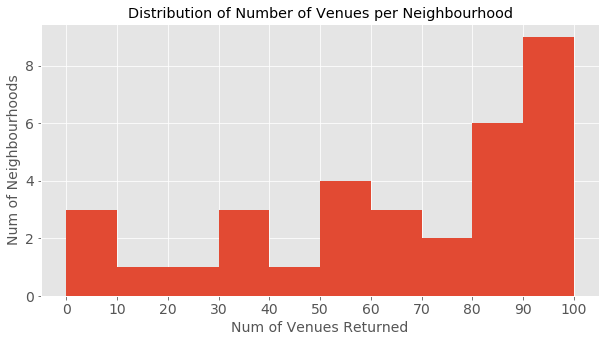

In [21]:
# count venues returned for each neighbourhood

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

venues_count_df = venues_df[['Neighbourhood', 'VenueName']].groupby('Neighbourhood', sort=False).count().reset_index()
venues_count_df.rename(columns={'VenueName': 'VenueCount'}, inplace=True)

matplotlib.style.use('ggplot')
venues_count_df.plot.hist(range=(0,100),
                          figsize=(10,5),
                          fontsize=14,
                          legend=False,
                          title='Distribution of Number of Venues per Neighbourhood',
                          xticks=np.linspace(0, 100, 11))

plt.xlabel('Num of Venues Returned', fontsize=14)
plt.ylabel('Num of Neighbourhoods', fontsize=14)


plt.show()

In [22]:
# make request with radius=750 and limit=150

venues_list = make_request(radius=750, limit=150)

venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
venues_df.columns = ['Neighbourhood', 'VenueName', 'VenueCategory', 'VenueLatitude', 'VenueLongitude']

venues_df.head()

,Neighbourhood,VenueName,VenueCategory,VenueLatitude,VenueLongitude
0,Harbourfront,Boxcar Social,Café,43.638319,-79.382463
1,Harbourfront,Pearl Harbourfront,Chinese Restaurant,43.638157,-79.380688
2,Harbourfront,Evviva Restaurant,Deli / Bodega,43.641580,-79.383456
3,Harbourfront,iQ Food Co,Salad Place,43.642851,-79.382081
4,Harbourfront,Aroma Espresso Bar,Café,43.642321,-79.383749


In [23]:
# check how many venues returned

venues_df.shape[0]

2843

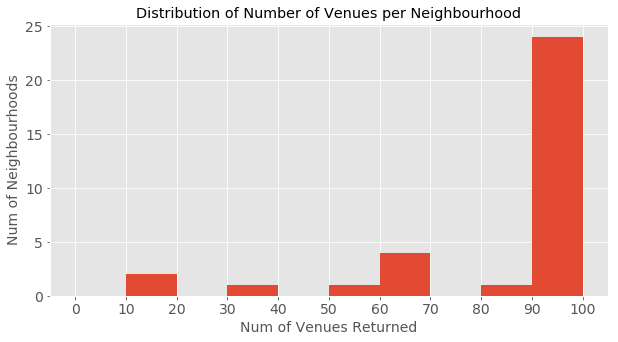

In [24]:
# distribution of venues returned for each neighbourhood

venues_count_df = venues_df[['Neighbourhood', 'VenueName']].groupby('Neighbourhood', sort=False).count().reset_index()
venues_count_df.rename(columns={'VenueName': 'VenueCount'}, inplace=True)

venues_count_df.plot.hist(range=(0,100),
                          figsize=(10,5),
                          fontsize=14,
                          legend=False,
                          title='Distribution of Number of Venues per Neighbourhood',
                          xticks=np.linspace(0, 100, 11))

plt.xlabel('Num of Venues Returned', fontsize=14)
plt.ylabel('Num of Neighbourhoods', fontsize=14)

plt.show()

In [25]:
# print some overall statistics for radius=750 and limit=150 request

print('We have {} venues across {} neighbourhoods.'.format(len(venues_df), len(venues_count_df)))
print('There are {} unique venue categories among those venues.'.format(len(venues_df['VenueCategory'].unique())))

We have 2843 venues across 33 neighbourhoods.
There are 86 unique venue categories among those venues.


In [26]:
# visualize downtown toronto venues on the map

location_toronto = [43.648503, -79.383558]
map_venues = folium.Map(location=location_toronto, zoom_start=13)

for lat, lng in zip(
    venues_df['VenueLatitude'],
    venues_df['VenueLongitude']):
    
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        parse_html=False).add_to(map_venues)  
    
map_venues

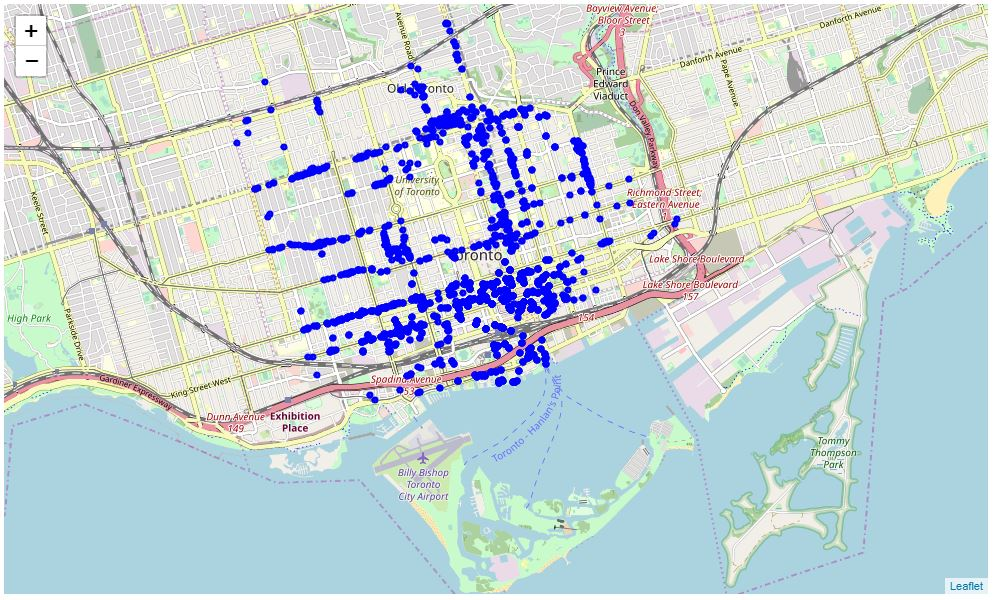

<a id='datawrangling'></a>

### 3.3. Data Wrangling and Preparation

In this section we will:
- Implement some initial data analysis of venue types distribution among selected neighbourhoods.
- One hot encode the dataframe from previous step, calculate average venue types frequencies for each neighbourhood (this will be an input dataframe for the machine learning clustering algorithm).
- Determine top 5 venue types for each neighbourhood and most common types of venues among all neighbourhoods.  

In [27]:
# check min and max number of venue categories for one neighbourhood

venues_unique_df = venues_df[['Neighbourhood', 'VenueCategory']]
venues_unique_df = venues_unique_df.groupby(by='Neighbourhood', sort=False).agg(lambda x: len(x.unique())).reset_index()
venues_unique_df.rename(columns={'VenueCategory': 'CategoryCount'}, inplace=True)

index_min = venues_unique_df['CategoryCount'].idxmin()
index_max = venues_unique_df['CategoryCount'].idxmax()

print('Min number of unique venue categories is {} for {}'.format(
    venues_unique_df.loc[index_min, 'CategoryCount'],
    venues_unique_df.loc[index_min, 'Neighbourhood']))
print('Max number of unique venue categories is {} for {}'.format(
    venues_unique_df.loc[index_max, 'CategoryCount'],
    venues_unique_df.loc[index_max, 'Neighbourhood']))

Min number of unique venue categories is 8 for Christie
Max number of unique venue categories is 50 for Kensington Market


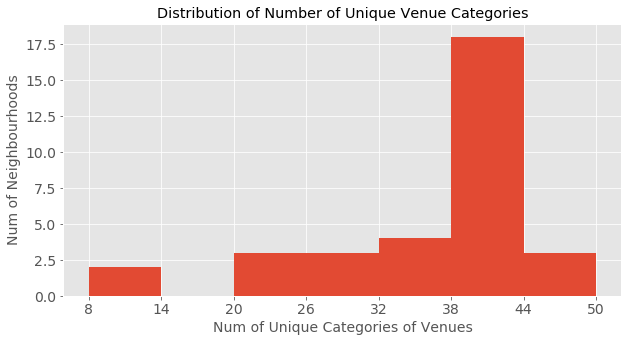

In [28]:
# distribution of number of unique venue categories

venues_unique_df.plot.hist(bins=7,
                           figsize=(10,5),
                           fontsize=14,
                           legend=False,
                           title='Distribution of Number of Unique Venue Categories',
                           xticks=np.linspace(venues_unique_df['CategoryCount'].min(), venues_unique_df['CategoryCount'].max(), 8)                          )

plt.xlabel('Num of Unique Categories of Venues', fontsize=14)
plt.ylabel('Num of Neighbourhoods', fontsize=14)

plt.show()

In [29]:
# one hot encoding
venues_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix='', prefix_sep='')

# add neighbourhood column back to dataframe
venues_onehot.insert(0, 'Neighbourhood', venues_df[['Neighbourhood']])

venues_onehot.shape

(2843, 87)

In [30]:
# groupby and take avg

venues_grouped = venues_onehot.groupby(by='Neighbourhood', sort=False).mean().reset_index()

venues_grouped.head()

,Neighbourhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Harbourfront,0.0,0.00,0.031746,0.00,0.00,0.000000,0.015873,0.000000,0.00,...,0.031746,0.047619,0.00,0.000000,0.0,0.015873,0.0,0.015873,0.000000,0.00
1,Regent Park,0.0,0.00,0.000000,0.00,0.00,0.032258,0.000000,0.032258,0.00,...,0.000000,0.032258,0.00,0.032258,0.0,0.129032,0.0,0.000000,0.032258,0.00
2,Ryerson,0.0,0.01,0.010000,0.02,0.04,0.000000,0.000000,0.060000,0.01,...,0.020000,0.010000,0.01,0.000000,0.0,0.000000,0.0,0.060000,0.020000,0.00
3,Garden District,0.0,0.00,0.020000,0.00,0.00,0.010000,0.000000,0.020000,0.00,...,0.010000,0.030000,0.01,0.000000,0.0,0.030000,0.0,0.010000,0.000000,0.01
4,St. James Town,0.0,0.00,0.025000,0.00,0.00,0.000000,0.000000,0.025000,0.00,...,0.025000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00


In [31]:
# check dataframe shape

venues_grouped.shape

(33, 87)

In [32]:
# transform into top 5 venue types for each neighbourhood

columns = ['Neighbourhood',
           '1stTopVenueType',
           '2ndTopVenueType',
           '3dTopVenueType',
           '4thTopVenueType',
           '5thTopVenueType']

venues_categ_sorted = pd.DataFrame(columns=columns)
num_top = 5

for i, row in venues_grouped.iterrows():
    venues_categ_sorted.loc[i, ['Neighbourhood']] = row.iloc[0]
    venues_categ_sorted.loc[i, ['1stTopVenueType',
                                '2ndTopVenueType',
                                '3dTopVenueType',
                                '4thTopVenueType',
                                '5thTopVenueType']] = row.iloc[1:].sort_values(ascending=False).index.array[:num_top]
    
venues_categ_sorted

,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
0,Harbourfront,Restaurant,Italian Restaurant,Café,Pizza Place,Sushi Restaurant
1,Regent Park,Thai Restaurant,Restaurant,Pizza Place,Café,Breakfast Spot
2,Ryerson,Italian Restaurant,Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery
3,Garden District,Café,Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place
4,St. James Town,Café,Pizza Place,Restaurant,Sandwich Place,Food Court
5,Berczy Park,Restaurant,Café,Italian Restaurant,Seafood Restaurant,Breakfast Spot
6,Central Bay Street,Italian Restaurant,Café,Restaurant,Sushi Restaurant,Japanese Restaurant
7,Christie,Diner,Italian Restaurant,Restaurant,Café,Vegetarian / Vegan Restaurant
8,Adelaide,Restaurant,Sandwich Place,Italian Restaurant,Asian Restaurant,Bakery
9,Richmond,Italian Restaurant,Restaurant,Bakery,Pizza Place,American Restaurant


In [33]:
# drop a column with 'restaurant' venue type and repeat groupby and transform from previous steps

venues_df = venues_df.loc[venues_df['VenueCategory'] != 'Restaurant']

venues_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix='', prefix_sep='')
venues_onehot.insert(0, 'Neighbourhood', venues_df[['Neighbourhood']])

print('Check one hot encoded dataframe shape: {}'.format(venues_onehot.shape))

venues_grouped = venues_onehot.groupby(by='Neighbourhood', sort=False).mean().reset_index()

for i, row in venues_grouped.iterrows():
    venues_categ_sorted.loc[i, ['Neighbourhood']] = row.iloc[0]
    venues_categ_sorted.loc[i, ['1stTopVenueType',
                                '2ndTopVenueType',
                                '3dTopVenueType',
                                '4thTopVenueType',
                                '5thTopVenueType']] = row.iloc[1:].sort_values(ascending=False).index.array[:num_top]
venues_categ_sorted

Check one hot encoded dataframe shape: (2603, 86)


,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
0,Harbourfront,Italian Restaurant,Café,Pizza Place,Food Court,Japanese Restaurant
1,Regent Park,Thai Restaurant,Pizza Place,Café,Breakfast Spot,Greek Restaurant
2,Ryerson,Italian Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Sandwich Place
3,Garden District,Café,Fast Food Restaurant,Sandwich Place,Pizza Place,Gastropub
4,St. James Town,Café,Sandwich Place,Pizza Place,Food Court,Japanese Restaurant
5,Berczy Park,Café,Italian Restaurant,Seafood Restaurant,Breakfast Spot,Gastropub
6,Central Bay Street,Italian Restaurant,Café,Sushi Restaurant,Mediterranean Restaurant,Indian Restaurant
7,Christie,Diner,Italian Restaurant,Café,Burger Joint,Vegetarian / Vegan Restaurant
8,Adelaide,Sandwich Place,Italian Restaurant,Pizza Place,Bakery,Asian Restaurant
9,Richmond,Italian Restaurant,Bakery,Pizza Place,Café,American Restaurant


In [34]:
# again print some overall statistics after removing 'restaurant' venue type  

venues_unique_df = venues_df[['Neighbourhood', 'VenueCategory']]
venues_unique_df = venues_unique_df.groupby(by='Neighbourhood', sort=False).agg(lambda x: len(x.unique())).reset_index()
venues_unique_df.rename(columns={'VenueCategory': 'CategoryCount'}, inplace=True)

index_min = venues_unique_df['CategoryCount'].idxmin()
index_max = venues_unique_df['CategoryCount'].idxmax()

print('After removing venue type \'Restaurant\':')
print('\tWe have {} venues across {} neighbourhoods.'.format(len(venues_df), len(venues_count_df)))
print('\tThere are {} unique venue categories among those venues.'.format(len(venues_df['VenueCategory'].unique())))
print('\tMin number of unique venue categories is {} for {}.'.format(
    venues_unique_df.loc[index_min, 'CategoryCount'],
    venues_unique_df.loc[index_min, 'Neighbourhood']))
print('\tMax number of unique venue categories is {} for {}.'.format(
    venues_unique_df.loc[index_max, 'CategoryCount'],
    venues_unique_df.loc[index_max, 'Neighbourhood']))

After removing venue type 'Restaurant':
	We have 2603 venues across 33 neighbourhoods.
	There are 85 unique venue categories among those venues.
	Min number of unique venue categories is 7 for Christie.
	Max number of unique venue categories is 49 for Kensington Market.


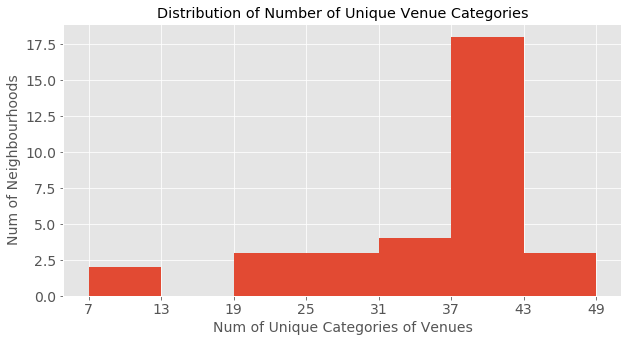

In [35]:
# distribution of number of unique venue categories after removing 'restaurant' venue type

venues_unique_df.plot.hist(bins=7,
                           figsize=(10,5),
                           fontsize=14,
                           legend=False,
                           title='Distribution of Number of Unique Venue Categories',
                           xticks=np.linspace(venues_unique_df['CategoryCount'].min(), venues_unique_df['CategoryCount'].max(), 8)                          )

plt.xlabel('Num of Unique Categories of Venues', fontsize=14)
plt.ylabel('Num of Neighbourhoods', fontsize=14)

plt.show()

In [36]:
# check the venues frequency values for top 5 venue types

venues_categ_sorted_freq = pd.DataFrame(columns=columns)

for i, row in venues_grouped.iterrows():
    venues_categ_sorted_freq.loc[i, ['Neighbourhood']] = row.iloc[0]
    venues_categ_sorted_freq.loc[i, ['1stTopVenueType',
                                     '2ndTopVenueType',
                                     '3dTopVenueType',
                                     '4thTopVenueType',
                                     '5thTopVenueType']] = row.iloc[1:].sort_values(ascending=False).array[:num_top]
venues_categ_sorted_freq

,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
0,Harbourfront,0.109091,0.0727273,0.0727273,0.0545455,0.0545455
1,Regent Park,0.148148,0.111111,0.111111,0.0740741,0.037037
2,Ryerson,0.0989011,0.0769231,0.0659341,0.0659341,0.0549451
3,Garden District,0.0967742,0.0645161,0.0537634,0.0537634,0.0537634
4,St. James Town,0.166667,0.111111,0.111111,0.0833333,0.0555556
5,Berczy Park,0.113636,0.0909091,0.0568182,0.0568182,0.0568182
6,Central Bay Street,0.129032,0.107527,0.0645161,0.0537634,0.0537634
7,Christie,0.2,0.2,0.2,0.1,0.1
8,Adelaide,0.0666667,0.0666667,0.0555556,0.0555556,0.0555556
9,Richmond,0.10989,0.0659341,0.0549451,0.043956,0.043956


In [37]:
# save the resulted venues dataframe to csv

venues_df.to_csv('final_dt_toronto_venues_df.csv')

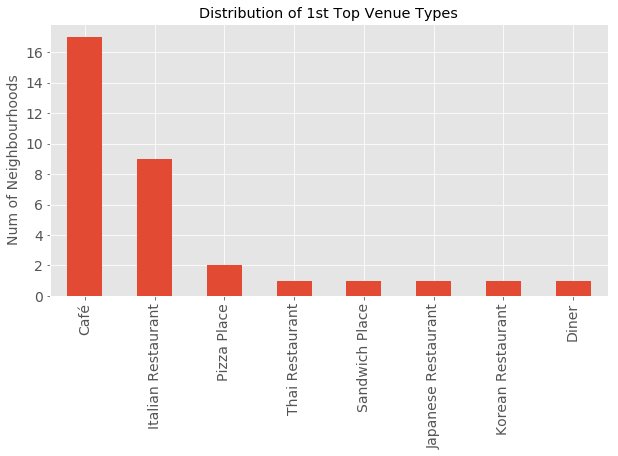

In [38]:
# distribution of top venue types

venues_categ_sorted['1stTopVenueType'].value_counts().plot.bar(figsize=(10,5),
                                                               fontsize=14,
                                                               title='Distribution of 1st Top Venue Types')

plt.ylabel('Num of Neighbourhoods', fontsize=14)
plt.show()

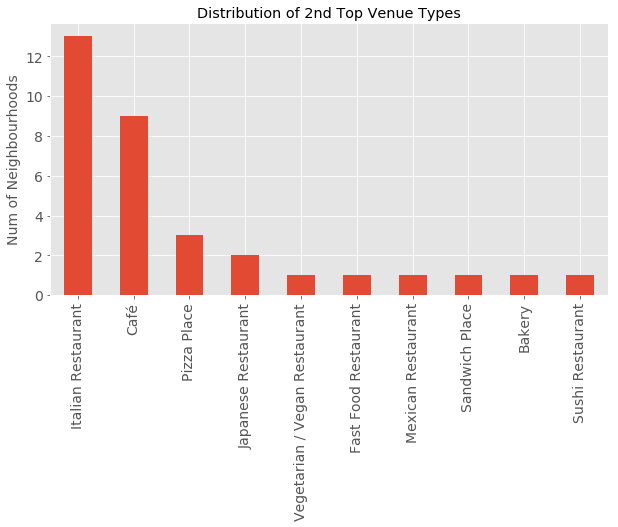

In [39]:
venues_categ_sorted['2ndTopVenueType'].value_counts().plot.bar(figsize=(10,5),
                                                               fontsize=14,
                                                               title='Distribution of 2nd Top Venue Types')
                                                              
plt.ylabel('Num of Neighbourhoods', fontsize=14)
plt.show()

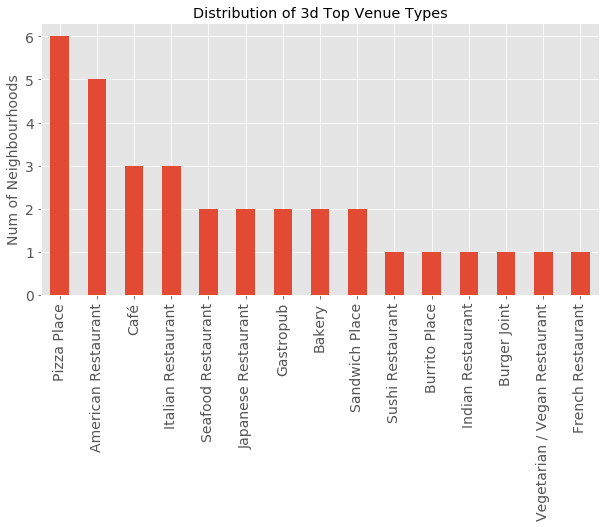

In [40]:
venues_categ_sorted['3dTopVenueType'].value_counts().plot.bar(figsize=(10,5),
                                                              fontsize=14,
                                                              title='Distribution of 3d Top Venue Types')
plt.ylabel('Num of Neighbourhoods', fontsize=14)
plt.show()

### First Observations

As an interim conclusion, we can see that the following restaurant **niches are already quite competitive** in Downtown Toronto:
- **Cafe**: the most common Top 1, the second common Top 2 and the third common Top 3 venue category among all neighbourhoods.
- **Italian Restaurant**: the second common Top 1 and the most common Top 2 venue category.
- **Pizza Place**: the third common Top 1, the third common Top 2 and the most common Top 3 venue category.
- **American Restaurant**: the most common Top 3 venue category.

<a id='clustering'></a>

### 3.4. Clustering Algorithm

Now we can feed the prepared data into the machine learning clustering algorithm and see the outcome. For this project our choice of clustering algorithm will be general-purpose [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means) implementation from scikit-learn. This algorithm requires the number of clusters to be specified, so we will:
- Define a function to experiment and run our clustering algorithm with different number of clusters to generate.
- Check the resulted distribution of neighbourhoods into specified number of clusters in terms of quantity.
- Look at the spatial distribution on the generated `folium` map.
- Choose the optimal model for further cluster examination and final recommendations.

We will run the clustering algorithm with the number of clusters set to 3, 5 and 7. Given that the total number of neighbourhoods being analysed is 33, there is no point into increasing that number any further. Otherwise we will be picking noise and not patterns.

In [41]:
# define model for kmeans clustering algorithm with n_clusters and map visualization

from sklearn.cluster import KMeans

# venues_categ_sorted.insert(0, 'ClusterLabels', np.nan)

def model(n_clusters=None):
    
    # extract training set for model 
    X = venues_grouped.iloc[:, 1:]

    # run kmeans clustering
    model = KMeans(n_clusters=n_clusters, random_state=0) 
    model.fit(X)
    
    # add clustering labels to venues_categ_sorted dataframe
    venues_categ_sorted['ClusterLabels'] = model.labels_
    
    # create joint toronto_venues_clusters dataframe
    toronto_venues_clusters = toronto_df.join(
        venues_categ_sorted.set_index('Neighbourhood'),
        on='Neighbourhood',
        how='right').reset_index(drop=True)
    
    # check how many neighbourhood in each cluster

    count_df = toronto_venues_clusters[['Neighbourhood', 'ClusterLabels']].groupby('ClusterLabels').count().reset_index()
    count_df.rename(columns={'Neighbourhood': 'NumNeighbourhoods'}, inplace=True)
    count_df['Percentage'] = round(100*count_df['NumNeighbourhoods']/count_df['NumNeighbourhoods'].sum(), 1)
    
    # create folium map
    map_clusters = folium.Map(location=location_toronto, zoom_start=13)

    colors_array = matplotlib.cm.Set1(np.linspace(0, 1, n_clusters))
    rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

    markers_colors = []
    for lat, lng, hood, cluster in zip(
        toronto_venues_clusters['Latitude'],
        toronto_venues_clusters['Longitude'],
        toronto_venues_clusters['Neighbourhood'],
        toronto_venues_clusters['ClusterLabels']):

        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup='{}\nCluster: {}'.format(hood, cluster),
            tooltip='{}\nCluster: {}'.format(hood, cluster),
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)


    return model.labels_, toronto_venues_clusters, count_df, map_clusters

### Segmenting into 3 Clusters

In [42]:
# run clustering algorithm with num_clusters=3

model.labels_3, toronto_venues_clusters_3, count_df_3, map_clusters_3 = model(n_clusters=3)
model.labels_3

array([1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

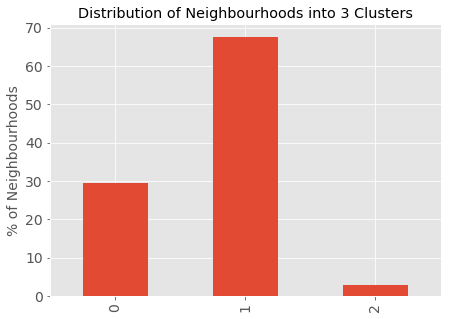

In [43]:
count_df_3.plot.bar(y='Percentage',
                  figsize=(7,5),
                  fontsize=14,
                  legend=False,
                  title='Distribution of Neighbourhoods into 3 Clusters')

plt.ylabel('% of Neighbourhoods', fontsize=14)
plt.show()

In [44]:
map_clusters_3

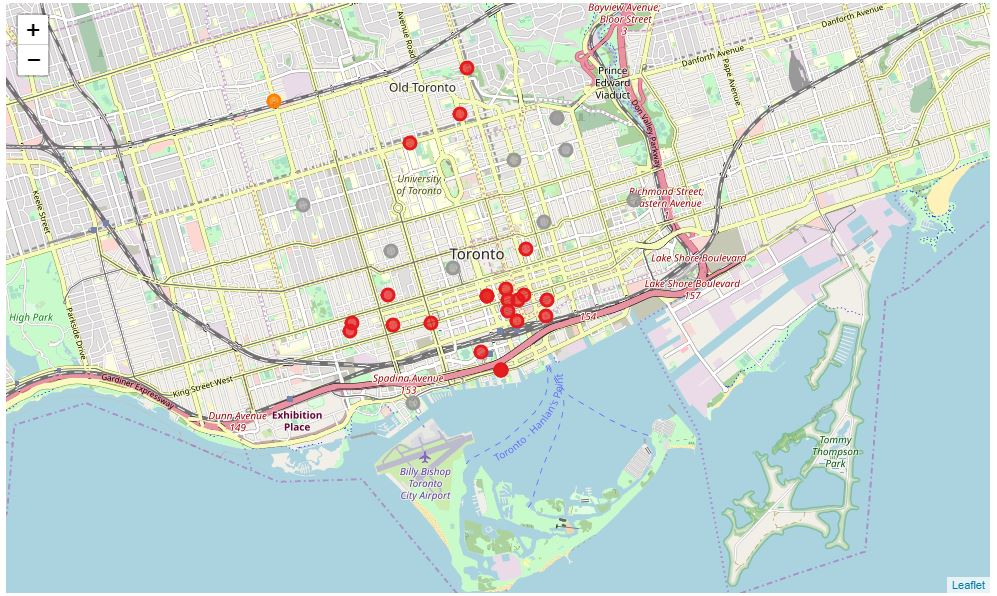

### Segmenting into 5 Clusters

In [45]:
# run clustering algorithm with num_clusters=5

model.labels_5, toronto_venues_clusters_5, count_df_5, map_clusters_5 = model(n_clusters=5)
model.labels_5

array([0, 3, 4, 3, 3, 1, 4, 2, 4, 4, 0, 1, 1, 1, 1, 1, 4, 4, 1, 3, 4, 0,
       3, 0, 4, 1, 4, 4, 1, 3, 1, 1, 3])

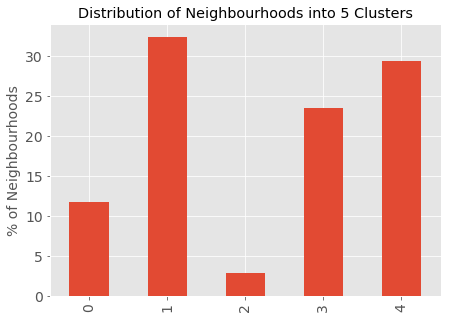

In [46]:
count_df_5.plot.bar(y='Percentage',
                  figsize=(7,5),
                  fontsize=14,
                  legend=False,
                  title='Distribution of Neighbourhoods into 5 Clusters')

plt.ylabel('% of Neighbourhoods', fontsize=14)
plt.show()

In [47]:
map_clusters_5

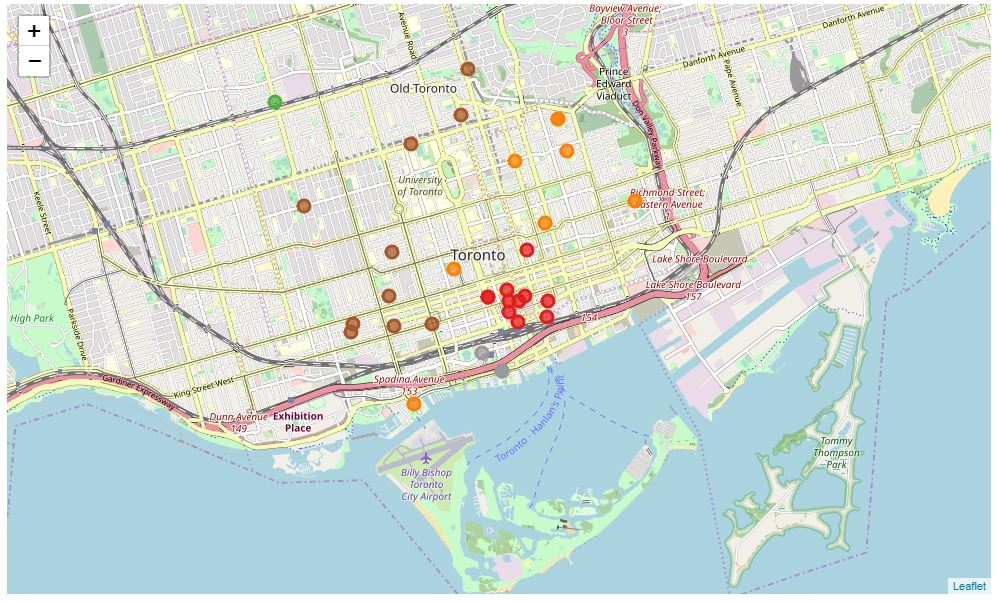

### Segmenting into 7 Clusters

In [48]:
# run clustering algorithm with num_clusters=7

model.labels_7, toronto_venues_clusters_7, count_df_7, map_clusters_7 = model(n_clusters=7)
model.labels_7

array([0, 3, 4, 3, 3, 1, 6, 2, 4, 4, 0, 1, 1, 1, 1, 1, 4, 6, 1, 3, 4, 0,
       5, 0, 4, 1, 4, 6, 1, 3, 1, 1, 3])

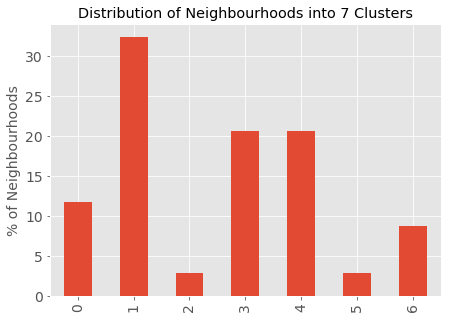

In [49]:
count_df_7.plot.bar(y='Percentage',
                  figsize=(7,5),
                  fontsize=14,
                  legend=False,
                  title='Distribution of Neighbourhoods into 7 Clusters')

plt.ylabel('% of Neighbourhoods', fontsize=14)
plt.show()

In [50]:
map_clusters_7

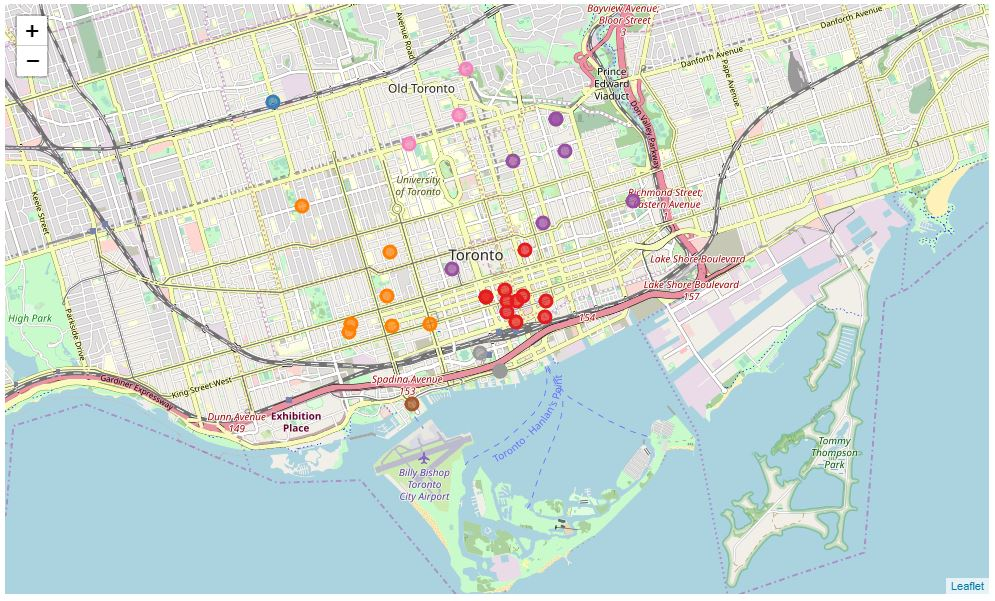

### Model Selection

Based on the results of clustering we can say that:
- Cluster 1 seems to dominate in all three models, though its domination in models with 5 and 7 clusters is more moderate. Thus we will be choosing from those two models with 5 and 7 clusters since they give more distributed clusters with spatial patterns we can get some insights from.
- As we can see further the model with 7 clusters, compared to the one with 5, further segments Cluster 3 and 4 into Clusters 5 and 6. Though the number of clusters to be 7 can be too many, if we look at the spatial distribution of neighbourhoods segmented into 7 clusters on the map we can notice some spatial patterns identified. So we will go ahead and examine further those 7 cluster and make our final recommendations based on that.

In [51]:
# save the resulted dataframe to csv

toronto_venues_clusters_7.to_csv('final_dt_toronto_venues_clusters.csv')

<a id='clusterexamination'></a>

### 3.5. Examining Clusters of Chosen Model

In [52]:
print(toronto_venues_clusters_7.shape)
toronto_venues_clusters_7.head()

(34, 11)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType,ClusterLabels
0,M5A,Downtown Toronto,Harbourfront,43.6395,-79.3832,Italian Restaurant,Café,Pizza Place,Food Court,Japanese Restaurant,0
1,M5A,Downtown Toronto,Regent Park,43.6607,-79.3603,Thai Restaurant,Pizza Place,Café,Breakfast Spot,Greek Restaurant,3
2,M5B,Downtown Toronto,Ryerson,43.6488,-79.4025,Italian Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Sandwich Place,4
3,M5B,Downtown Toronto,Garden District,43.6579,-79.3756,Café,Fast Food Restaurant,Sandwich Place,Pizza Place,Gastropub,3
4,M5C,Downtown Toronto,St. James Town,43.6708,-79.3735,Café,Sandwich Place,Pizza Place,Food Court,Japanese Restaurant,3


In [53]:
# check again the distribution of neighbourhoods in the model in table format

count_df_7

,ClusterLabels,NumNeighbourhoods,Percentage
0,0,4,11.8
1,1,11,32.4
2,2,1,2.9
3,3,7,20.6
4,4,7,20.6
5,5,1,2.9
6,6,3,8.8


In [54]:
columns = ['ClusterLabels',
           'Neighbourhood',
           '1stTopVenueType',
           '2ndTopVenueType',
           '3dTopVenueType',
           '4thTopVenueType',
           '5thTopVenueType']

### Cluster 0

In [55]:
cluster0 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 0]
cluster0

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
0,0,Harbourfront,Italian Restaurant,Café,Pizza Place,Food Court,Japanese Restaurant
11,0,Harbourfront East,Italian Restaurant,Café,Pizza Place,Food Court,Japanese Restaurant
22,0,CN Tower,Pizza Place,Café,Italian Restaurant,Japanese Restaurant,Sandwich Place
24,0,Harbourfront West,Italian Restaurant,Café,Pizza Place,Food Court,Japanese Restaurant


Cluster 0 geographically comprises 4 neighbourhoods at **Harbourfront area**.

Its distinguishing venue categories in terms of restaurant niches seem to be **Italian Restaurant** and **Pizza Places** (either Top 1 or Top 3 venue categories). **Japanese Restaurant** is the next most common type of cuisine among restaurants in that cluster. Also we need to note that such venue type as **Cafe** is the most common Top 2 category. 

### Cluster 1

In [56]:
cluster1 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 1]
cluster1

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
6,1,Berczy Park,Café,Italian Restaurant,Seafood Restaurant,Breakfast Spot,Gastropub
12,1,Union Station,Café,Italian Restaurant,American Restaurant,Steakhouse,Deli / Bodega
13,1,Design Exchange,Café,Italian Restaurant,Seafood Restaurant,American Restaurant,Gastropub
14,1,Toronto Dominion Centre,Café,Italian Restaurant,American Restaurant,Steakhouse,Salad Place
15,1,Commerce Court,Café,Italian Restaurant,Gastropub,Seafood Restaurant,Bakery
16,1,Victoria Hotel,Café,Italian Restaurant,Gastropub,Japanese Restaurant,American Restaurant
19,1,Chinatown,Café,Japanese Restaurant,Italian Restaurant,American Restaurant,Pizza Place
26,1,Railway Lands,Café,Japanese Restaurant,Italian Restaurant,American Restaurant,Pizza Place
29,1,Stn A PO Boxes 25 The Esplanade,Café,Italian Restaurant,American Restaurant,Gastropub,Bakery
31,1,First Canadian Place,Café,Italian Restaurant,American Restaurant,Steakhouse,Gastropub


Cluster 1 comprises 11 neighbourhoods (10 of them very densely located) around **Financial** and **Entertainment** districts in the city centre.

In terms of restaurant niches again **Italian Restaurant** seems to be a distinguishing venue category for this cluster (most common Top 2 venue category), along with **American Restaurant** which is the second most common type. Although among all venue types in this cluster the most common is **Cafe**.	

### Cluster 2

In [57]:
cluster2 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 2]
cluster2

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
8,2,Christie,Diner,Italian Restaurant,Café,Burger Joint,Vegetarian / Vegan Restaurant


Cluster 2 is a single neighbourhood cluster located on the north-west outskirts of the central city area.

As we can see from the table of top venue types frequencies for **Christie** neighbourhood, first three top venue types (*Diner, Italian Restaurant and Cafe*) equally represent 20% of all its venues analysed.

Given that the total number of venues returned from our Foursquare request is just 10 and that this cluster consists of only one neighbourhood, it seems to be of low information value for our project.

In [58]:
venues_categ_sorted_freq[venues_categ_sorted_freq['Neighbourhood'] == 'Christie']

,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
7,Christie,0.2,0.2,0.2,0.1,0.1


In [59]:
venues_christie = venues_df[venues_df['Neighbourhood'] == 'Christie']
print('Total number of venues returned for Christie neighbourhood is {}.'.format(len(venues_christie)))
venues_christie

Total number of venues returned for Christie neighbourhood is 10.


,Neighbourhood,VenueName,VenueCategory,VenueLatitude,VenueLongitude
534,Christie,Contra Cafe,Café,43.669107,-79.426105
535,Christie,Vinny’s Panini,Italian Restaurant,43.670679,-79.426148
536,Christie,Universal Grill,Diner,43.670550,-79.426541
537,Christie,Gordo Ex,Latin American Restaurant,43.671763,-79.413845
540,Christie,Scout and Cash Caffe,Café,43.667360,-79.419938
541,Christie,Annapurna Vegetarian Restaurant,Vegetarian / Vegan Restaurant,43.672804,-79.414087
542,Christie,Vesta Lunch,Burger Joint,43.673233,-79.414270
543,Christie,Annabelle Pasta Bar,Italian Restaurant,43.675445,-79.423341
544,Christie,KOS,Diner,43.672248,-79.414204
545,Christie,Apollo 11,Breakfast Spot,43.672972,-79.414265


### Cluster 3

In [60]:
cluster3 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 3]
cluster3

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
1,3,Regent Park,Thai Restaurant,Pizza Place,Café,Breakfast Spot,Greek Restaurant
3,3,Garden District,Café,Fast Food Restaurant,Sandwich Place,Pizza Place,Gastropub
4,3,St. James Town,Café,Sandwich Place,Pizza Place,Food Court,Japanese Restaurant
5,3,St. James Town,Café,Sandwich Place,Pizza Place,Food Court,Japanese Restaurant
20,3,Grange Park,Café,Pizza Place,Japanese Restaurant,Sushi Restaurant,Steakhouse
30,3,Cabbagetown,Pizza Place,Café,Japanese Restaurant,American Restaurant,Breakfast Spot
33,3,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Burger Joint,Café,Sandwich Place


Cluster 3 consists of 7 neighbourhoods relatively scattered but most within the same area next to the cluster 1 to the north. This cluster includes among others areas around: University of Toronto, Government of Ontario, a relatively large number of Park and Garden areas.

In terms of restaurant niches this cluster looks more diverse with no particular cuisine dominating. Though we can see that **Asian Cuisine** types of restaurants (Thai, Japanese, Sushi) and **Pizza Places** are more common than other types of venues. Overall **Cafe** is the most common Top 1 venue type. 

### Cluster 4

In [61]:
cluster4 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 4]
cluster4

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
2,4,Ryerson,Italian Restaurant,Café,Vegetarian / Vegan Restaurant,Bakery,Sandwich Place
9,4,Adelaide,Sandwich Place,Italian Restaurant,Pizza Place,Bakery,Asian Restaurant
10,4,Richmond,Italian Restaurant,Bakery,Pizza Place,Café,American Restaurant
17,4,Harbord,Korean Restaurant,Italian Restaurant,Café,Sandwich Place,Pizza Place
21,4,Kensington Market,Café,Vegetarian / Vegan Restaurant,Bakery,Vietnamese Restaurant,Sandwich Place
25,4,King and Spadina,Italian Restaurant,Café,French Restaurant,Pizza Place,Thai Restaurant
27,4,South Niagara,Italian Restaurant,Pizza Place,Bakery,Café,Asian Restaurant


Cluster 4 is quite similar to cluster 3 in terms of spatial distribution and the number of neighbourhoods in it. It also consists of 7 neighbourhoods relatively scattered but most within the same area next to the cluster 1 but to the west. This cluster is located around **Fashion and Queen Street West** districts, it also includes **Kensington Market** and **Harbord** areas.

Its distinguishing restaurant category is again **Italian Restaurant** (most common top 1 and quite common Top 2 venue type), though not that dominating as in Clusters 0 or 1. We can also see some **Asian Cuisine** popularity with Korean, Vietnamese, Thai and Asian restaurants in Top 5, as well as in Top 4 and Top 1.

### Cluster 5

In [62]:
cluster5 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 5]
cluster5

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
23,5,Bathurst Quay,Café,Mexican Restaurant,Burrito Place,Diner,Pizza Place


Similar to Cluster 2 Cluster 5 is also a single neighbourhood cluster located at **Bathurst Quay**.

As we can see from the table of top venue types frequencies for Bathurst Quay neighbourhood, only the top venue type (which is Cafe) is more common than any other types equally represented in this neighbourhood. The total number of venues returned from the Foursquare request is 16. Takeaway for our recommendation is that this neighbourhood is quite diverse in terms of restaurant categories.

In [63]:
venues_categ_sorted_freq[venues_categ_sorted_freq['Neighbourhood'] == 'Bathurst Quay']

,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
22,Bathurst Quay,0.3125,0.0625,0.0625,0.0625,0.0625


In [64]:
venues_bathurst = venues_df[venues_df['Neighbourhood'] == 'Bathurst Quay']
print('Total number of venues returned for Bathurst Quay neighbourhood is {}.'.format(len(venues_bathurst)))
venues_bathurst

Total number of venues returned for Bathurst Quay neighbourhood is 16.


,Neighbourhood,VenueName,VenueCategory,VenueLatitude,VenueLongitude
1902,Bathurst Quay,Sansotei Ramen,Ramen Restaurant,43.639176,-79.398184
1903,Bathurst Quay,Roywoods,Caribbean Restaurant,43.639099,-79.398449
1904,Bathurst Quay,touti gelati and café,Café,43.636923,-79.396600
1905,Bathurst Quay,Rose's New York,Diner,43.638945,-79.398943
1906,Bathurst Quay,Music Garden Cafe,Café,43.637413,-79.393198
1907,Bathurst Quay,Guirei Sushi,Sushi Restaurant,43.636867,-79.396927
1908,Bathurst Quay,Parisco Cafe,Café,43.635955,-79.404331
1909,Bathurst Quay,Iruka Sushi,Japanese Restaurant,43.636901,-79.396610
1910,Bathurst Quay,Fort York Pizzeria,Pizza Place,43.636589,-79.405159
1911,Bathurst Quay,Liberty Shawarma,Falafel Restaurant,43.640978,-79.393261


### Cluster 6

In [65]:
cluster6 = toronto_venues_clusters_7[columns].loc[toronto_venues_clusters_7['ClusterLabels'] == 6]
cluster6

,ClusterLabels,Neighbourhood,1stTopVenueType,2ndTopVenueType,3dTopVenueType,4thTopVenueType,5thTopVenueType
7,6,Central Bay Street,Italian Restaurant,Café,Sushi Restaurant,Mediterranean Restaurant,Indian Restaurant
18,6,University of Toronto,Café,Italian Restaurant,Sandwich Place,Bakery,French Restaurant
28,6,Rosedale,Italian Restaurant,Café,Indian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant


Our final Cluster 6 comprises just 3 neighbourhoods further north from the city centre around **Old Toronto**, and a bit north from **University of Toronto**.

The most common restaurant category in this cluster is again **Italian Restaurant**. Other less common cuisines are quite diverse with no distinguishable next most common type. Though **Indian** and **French** restaurants seem to be slightly more common.

<a id='results'></a>

## 4. Results

To summarize the results of our analysis and underlying data that went into it:
- We identified 34 neighbourhoods in mainland Downtown Toronto that we wanted to explore in this project.
- Foursquare API request returned 2603 venues across those 33 neighbourhoods within the radius of 750 meters. For most neighbourhoods (24 out of 33 or more than 70%) the number of returned venues was between 90 and 100.
- There are 85 unique venue categories among those venues. Minimum number of unique venue categories is 7 for Christie neighbourhood, maximum - 49 for Kensington Market. For more than 50% of neighbourhoods the number of unique venue types is between 37 and 43. For more than 70 % of neighbourhoods that number is between 31 and 49.
- Distribution of first, second and third top venue types among all neighbourhoods shows that the most common types there are: Cafe, Italian Restaurant, Pizza Place and American Restaurant.
- After running K-means clustering algorithm with the number of clusters set to 3, 5 and 7 the model with 7 clusters was chosen. It provides more distributed clusters with spatial patterns we can get some insights from.
- Further cluster examination identified one cluster of lower information value for our project. The results of analysis of the most common venue types in terms of restaurant cuisines for other 6 clusters are summarised in the table below.


Cluster | Most common cuisine | Second most common cuisine
--- | --- | --- 
Cluster 0 | Italian Restaurant, Pizza Place | Japanese Restaurant
Cluster 1 | Italian Restaurant | American Restaurant
Cluster 3 | Asian (Thai, Japanese and Sushi restaurants), Pizza Place – more common | All other types are equally common
Cluster 4 | Italian Restaurant | Asian (Korean, Vietnamese, Thai and Asian restaurants)
Cluster 5 | No particular type | No particular type
Cluster 6 | Italian Restaurant | Indian and French Restaurants – slightly more common than others

<a id='discussion'></a>

## 5. Discussion

Based on the results of the analysis summarized above we can say that:
- Data collection provided us with sufficient number of venues and diversity of their types among all neighbourhoods analysed for further aggregation, frequency analysis and clustering.   
- Overall distribution of the most common types of venues among all neighbourhoods shows that there are overall some particularly competitive niches (*Cafe, Italian Restaurant, Pizza Place and American Restaurant*) in Downtown Toronto. Those venue types are more common than others and further and deeper market analysis is recommended to understand the supply-demand dynamic in those niches.
- The machine learning K-means clustering algorithm resulted in 7 clusters spatially separated on the map and with distinguishing venue types that are more common within each cluster.
- Further examination identified restaurant niches that might be more competitive (since they are more common types) in each cluster.

That provides the basis for further analysis so that the stakeholders can make more informative decision about what restaurant niches and in what cluster they want to invest. For example, the initial analysis shows that Italian Restaurant niche is very competitive in at least 4 clusters identified. But further analysis of more detailed Foursquare statistics for each venue of this type can show that the current popularity of venues of this type is so high that there is definitely demand for more Italian restaurants.

The example of such detailed Foursquare statistics can be: `checkinsCount`, `usersCount`, `tipCount`, `rating`, `hours`, `popular` and others. It should be noted though that getting that detailed statistics is possible only through Foursquare Premium API requests.

<a id='conclusion'></a>

## 6. Conclusion

The purpose of this training project was to:
- Explore the current spatial distribution of all restaurants in Downtown Toronto based on Foursquare location data.
- Use the machine learning clustering algorithm to identify different restaurant clusters.
- Help potential stakeholders, who plan to invest in the idea of opening a restaurant in Downtown Toronto, to answer the following question: *Where would we recommend our potential stakeholders open it and whether they should pursue opening some particular type or types of restaurants that they think of?*

During this project we implemented steps and stages of a data science project, including:
- Problem Definition.
- Data Collection.
- Data Analysis.
- Wrangling and Preparation.
- Model Selection and
- Report Writing. 

Based on the results of the analysis we were able to communicate initial observations and recommendations. Those observations and recommendations can be used by stakeholders to guide further more detailed analysis to make the final decision.